In [1]:
import math
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random

%matplotlib inline
plt.rcParams.update({
        'font.size': 14,
        'axes.titlesize': 20,
        'axes.labelsize': 20,
        'xtick.labelsize': 20,
        'ytick.labelsize': 20,
        'font.size': 20,
        'figure.figsize': (10, 7),
        'axes.grid': True,
        'grid.linestyle': '-',
        'grid.alpha': 0.3,
        'lines.markersize': 5.0,
        'xtick.minor.visible': True,
        'xtick.direction': 'in',
        'xtick.major.size': 20.0,
        'xtick.minor.size': 10.0,
        'xtick.top': False,
        'xtick.bottom': True,
        'ytick.minor.visible': True,
        'ytick.direction': 'in',
        'ytick.major.size': 12.0,
        'ytick.minor.size': 6.0,
        'ytick.right': True,
        'errorbar.capsize': 0.0,
    })

# https://www.kaggle.com/competitions/practical-ml-chocolate/data
# https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings/

# Get data

In [2]:
df_train = pd.read_csv('chocolate_train.csv')
df_test = pd.read_csv('chocolate_test_new.csv')
df_train.head()

,Company,Specific Bean Origin,REF,Review,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,Willie's Cacao,Rio Caribe,457,2009,72%,U.K.,3.25,Trinitario,Venezuela
1,Beschle (Felchlin),"Ocumare, Premier Cru, Quizas No. 2",508,2010,72%,Switzerland,3.50,,Venezuela
2,Dark Forest,Tanzania,1554,2015,70%,U.S.A.,3.00,,Tanzania
3,Brasstown aka It's Chocolate,Cooproagro,1125,2013,72%,U.S.A.,3.00,Trinitario,Dominican Republic
4,Pralus,"Java, Indonesie",32,2006,75%,France,3.50,Criollo,Indonesia


In [3]:
print(f'Train data has {df_train.shape[1]} columns and {df_train.shape[0]} rows')
print(f'Train data has {df_test.shape[1]} columns and {df_test.shape[0]} rows')

Train data has 9 columns and 1255 rows
Train data has 8 columns and 540 rows


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Company               1255 non-null   object 
 1   Specific Bean Origin  1255 non-null   object 
 2   REF                   1255 non-null   int64  
 3   Review                1255 non-null   int64  
 4   Cocoa Percent         1255 non-null   object 
 5   Company Location      1255 non-null   object 
 6   Rating                1255 non-null   float64
 7   Bean Type             1254 non-null   object 
 8   Broad Bean Origin     1254 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 88.4+ KB


In [5]:
# Make percentage float
df_train['Cocoa Percent'] = df_train['Cocoa Percent'].apply(lambda x: float(x.strip('%')))
df_test['Cocoa Percent'] = df_test['Cocoa Percent'].apply(lambda x: float(x.strip('%')))

In [6]:
df_train.describe()

,REF,Review,Cocoa Percent,Rating
count,1255.000000,1255.000000,1255.000000,1255.000000
mean,1045.152191,2012.382470,71.790438,3.176494
std,551.284249,2.922499,6.397448,0.478948
min,5.000000,2006.000000,46.000000,1.000000
25%,593.000000,2010.000000,70.000000,2.750000
50%,1077.000000,2013.000000,70.000000,3.250000
75%,1514.000000,2015.000000,75.000000,3.500000
max,1952.000000,2017.000000,100.000000,5.000000


## Fill NaNs and empty cells

In [7]:
df_train.isna().sum()

Company                 0
Specific Bean Origin    0
REF                     0
Review                  0
Cocoa Percent           0
Company Location        0
Rating                  0
Bean Type               1
Broad Bean Origin       1
dtype: int64

In [8]:
mode_bean_type = df_train['Bean Type'].mode()[0]
mode_broad_bean_origin = df_train['Broad Bean Origin'].mode()[0]

df_train['Bean Type'].fillna(mode_bean_type, inplace=True)
df_train['Broad Bean Origin'].fillna(mode_broad_bean_origin, inplace=True)

In [9]:
empty_cell = df_train['Bean Type'].value_counts().index[0]

In [10]:
mode_bean_type = df_train.loc[df_train['Bean Type']!=empty_cell, 'Bean Type'].mode()[0]

In [11]:
df_train['Bean Type'] = df_train['Bean Type'].replace(empty_cell, mode_bean_type)
df_test['Bean Type'] = df_test['Bean Type'].replace(empty_cell, mode_bean_type)

In [12]:
mode_broad_bean_origin = df_train['Broad Bean Origin'].mode()[0]
mode_broad_bean_origin
df_train['Broad Bean Origin'] = df_train['Broad Bean Origin'].replace(empty_cell, mode_broad_bean_origin)
df_test['Broad Bean Origin'] = df_test['Broad Bean Origin'].replace(empty_cell, mode_broad_bean_origin)

# EDA

In [13]:
print('List of features:', '-'*25, sep='\n')
for i in df_train.drop('Rating', axis=1).columns:
    print(i)

List of features:
-------------------------
Company
Specific Bean Origin
REF
Review
Cocoa Percent
Company Location
Bean Type
Broad Bean Origin


In [14]:
train_target = df_train['Rating']
df_train.drop(['Rating'], axis=1, inplace=True)
df_train['Rating'] = train_target

## Correlation matrix (numeric features)

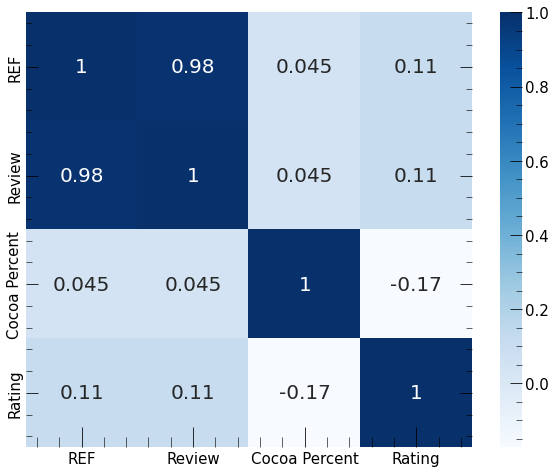

In [15]:
plt.figure(figsize = (10,8))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

## Correlation matrix (categorical features)

In [16]:
import association_metrics as am

XC = df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin
Company,1.000000,0.771074,0.999651,0.615394,0.603022
Specific Bean Origin,0.771074,1.000000,0.808500,0.907379,0.983510
Company Location,0.999651,0.808500,1.000000,0.289971,0.381918
Bean Type,0.615394,0.907379,0.289971,1.000000,0.370471
Broad Bean Origin,0.603022,0.983510,0.381918,0.370471,1.000000


Correlated features (may drop one from each pair):
* REF and Review
* Company and Company Location
* Broad Bean Origin and Specific Bean Origin
* Specific Bean Origin and Bean Type

From every pair of highly correlated categorical features we should drop the one with maximum unique values to avoid overfitting

## Outliers

In [17]:
cat_cols = df_train.columns[df_train.dtypes == 'object']
num_cols = df_train.columns[df_train.dtypes != 'object']

REF


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


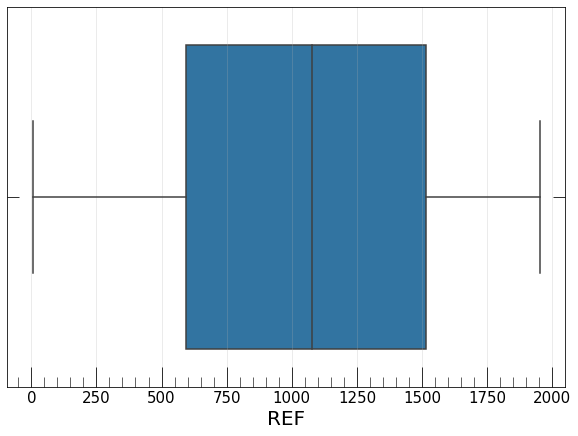

Review


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


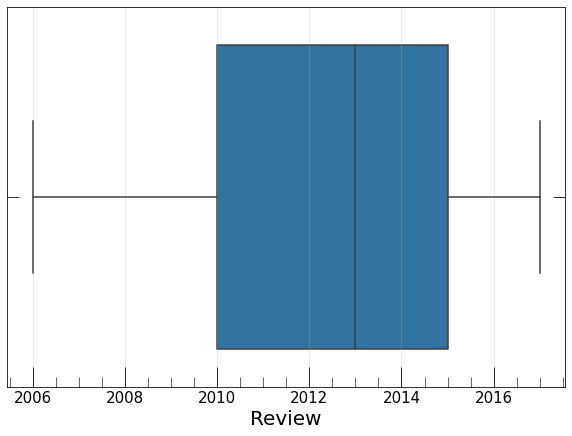

Cocoa Percent


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


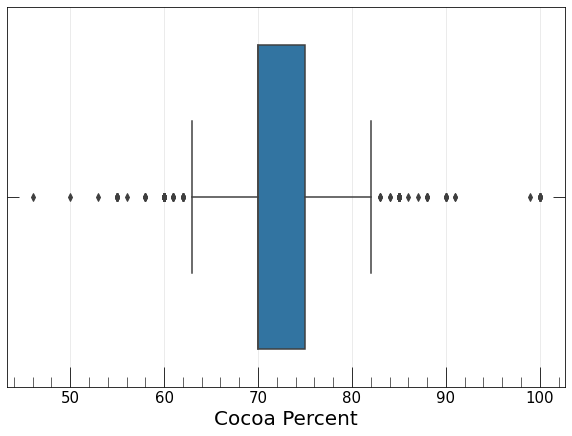

Rating


/home/andy/miniconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


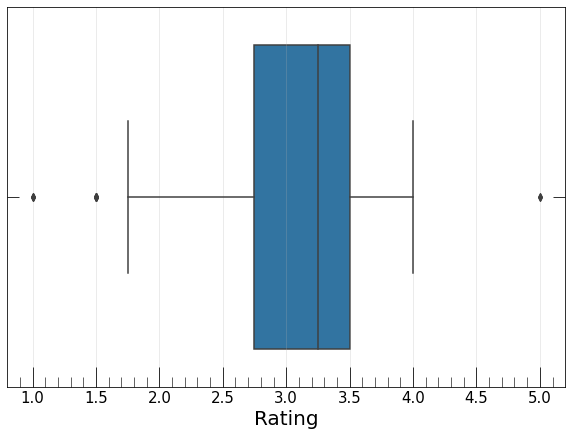

In [18]:
for col in num_cols:
    print(col)
    sns.boxplot(df_train[col])
    plt.show()

In [19]:
outliers_cocoa_percent = df_train[(df_train['Cocoa Percent'] >= 99) | (df_train['Cocoa Percent'] <= 50)]
df_train = df_train.drop(outliers_cocoa_percent.index, axis=0)

outliers_cocoa_percent_test = df_train[(df_train['Cocoa Percent'] >= 99) | (df_train['Cocoa Percent'] <= 50)]
df_test = df_test.drop(outliers_cocoa_percent_test.index, axis=0)

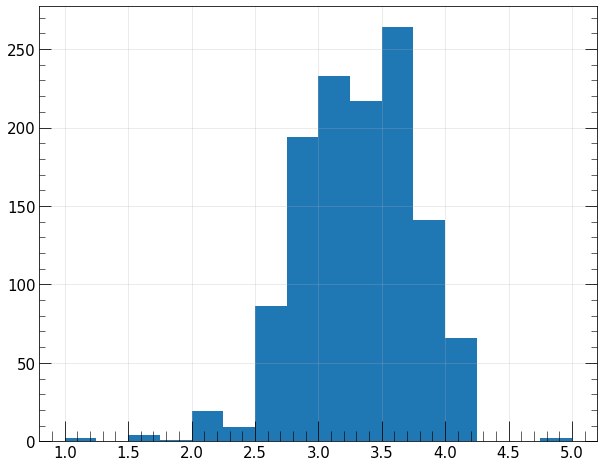

In [20]:
plt.figure(figsize=(10, 8))
plt.hist(df_train['Rating'], bins=16)
plt.show()

In [21]:
#outliers_rating = df_train[(df_train['Rating'] == 5.0) | (df_train['Rating'] <= 1.5)]
#df_train = df_train.drop(outliers_rating.index, axis=0)

# Baseline model (ansamble)

In [22]:
from sklearn.model_selection import train_test_split

X = df_train.drop('Rating', axis=1)
y = df_train.Rating

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

from category_encoders.ordinal import OrdinalEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.target_encoder import TargetEncoder
from category_encoders.leave_one_out import LeaveOneOutEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import GridSearchCV

In [24]:
from sklearn.pipeline import Pipeline

p_baseline = Pipeline([
    ('encoder', TargetEncoder(cols=cat_cols)),
    ('scaler', StandardScaler()),
    ('model', RandomForestRegressor(n_jobs=-1))
])

p_baseline.fit(X_train, y_train)
pred = p_baseline.predict(X_val)
r2_score(y_val, pred)

0.0798670856591086

In [25]:
# Parameters of pipelines can be set using '__' separated parameter names:
param_grid = {
    "model__n_estimators": [180, 200],
    "model__max_depth": [3, 4, 5],
    "model__min_samples_split": [10, 15, 20],
    #"model__min_samples_leaf": []
    #"criterion": ["squared_error", "absolute_error", "friedman_mse", "poisson"],
}
search = GridSearchCV(p_baseline, param_grid, cv=3, n_jobs=-1, scoring='r2')
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=-0.014):
{'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}


In [26]:
search.best_estimator_.fit(X_train, y_train)
pred = search.best_estimator_.predict(X_val)
r2_score(y_val, pred)

0.08829415081531466

Not a great result

# CatBoost

In [27]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([0, 1, 5, 6, 7])

In [28]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_val, y_val),
         logging_level='Silent')

pred = model.predict(X_val)

r2_score(y_val, pred)

0.16250575333302097

In [29]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,30.570633
4,Cocoa Percent,15.927746
6,Bean Type,14.402990
7,Broad Bean Origin,11.580571
2,REF,10.277128
5,Company Location,9.594256
3,Review,7.420493
1,Specific Bean Origin,0.226184


## CatBoost hyperparameters tuning

In [30]:
from sklearn.metrics import mean_squared_error

In [31]:
import optuna

def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 2, 16),
    }

    estimator = CatBoostRegressor(**param,
                                  cat_features=categorical_features_indices,
                                  verbose=False)

    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_val)

    return mean_squared_error(y_val, pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, n_jobs=-1)
print(study.best_trial)

[I 2023-07-09 20:11:15,024] A new study created in memory with name: no-name-4cb3a4fd-6839-4ec3-afd8-f14ef1069316
[I 2023-07-09 20:11:18,623] Trial 0 finished with value: 0.1870422032233899 and parameters: {'n_estimators': 568, 'max_depth': 5}. Best is trial 0 with value: 0.1870422032233899.
[I 2023-07-09 20:11:22,862] Trial 4 finished with value: 0.1889148125352943 and parameters: {'n_estimators': 511, 'max_depth': 5}. Best is trial 0 with value: 0.1870422032233899.
[I 2023-07-09 20:11:27,277] Trial 1 finished with value: 0.1939702086858541 and parameters: {'n_estimators': 835, 'max_depth': 7}. Best is trial 0 with value: 0.1870422032233899.
[I 2023-07-09 20:11:27,946] Trial 3 finished with value: 0.1950221413352084 and parameters: {'n_estimators': 590, 'max_depth': 8}. Best is trial 0 with value: 0.1870422032233899.
[I 2023-07-09 20:11:33,310] Trial 5 finished with value: 0.19261850388046614 and parameters: {'n_estimators': 944, 'max_depth': 6}. Best is trial 0 with value: 0.18704220

FrozenTrial(number=14, state=TrialState.COMPLETE, values=[0.1761782459114539], datetime_start=datetime.datetime(2023, 7, 9, 20, 12, 4, 860350), datetime_complete=datetime.datetime(2023, 7, 9, 20, 12, 5, 216667), params={'n_estimators': 54, 'max_depth': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=16, log=False, low=2, step=1)}, trial_id=14, value=None)


In [32]:
print(study.best_trial.params)

{'n_estimators': 54, 'max_depth': 2}


In [33]:
model = CatBoostRegressor(**study.best_params,
                         cat_features=categorical_features_indices,
                         logging_level='Silent')

model.fit(X_train, y_train)
pred_cb = model.predict(X_val)

r2_score(y_val, pred_cb)

0.1739778459538498

In [34]:
model.fit(X, y)

That's better already, let's try it on test

In [35]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,34.484726
2,REF,21.411518
4,Cocoa Percent,15.929413
1,Specific Bean Origin,8.004881
5,Company Location,5.754834
6,Bean Type,5.176913
7,Broad Bean Origin,4.746048
3,Review,4.491667


## Apply tuned CatBoost to test

In [36]:
pred_test = model.predict(df_test)
pred_test[:10]

array([3.10689607, 3.22236415, 3.0212848 , 3.30236717, 3.01346754,
       3.02015426, 3.009542  , 3.1438141 , 3.20006667, 2.69979566])

In [37]:
df_submission = df_test.copy()
df_submission['id'] = np.arange(len(df_test))
df_submission['Rating'] = pred_test
df_submission = df_submission[['id','Rating']]
df_submission.to_csv("CatBoost_v1.csv", index=False)

This model gives r2 = 0.16608 on test. <br>
Which is not very bad but still we must achieve r2 >= 0.2

# Feature engineering

Some ideas I already tried:
* Broad company location (Africa, Caribbean, etc)
* Broader cocoa bean origin (Africa, Caribbean, etc)
* Best Companies (from internet sources)
* Top cocoa bean production countries (amount and quality)

More to try:
* Company location matches broad bean origin

### Matched Regions

In [38]:
df_train[['Company Location', 'Broad Bean Origin']].head()

,Company Location,Broad Bean Origin
0,U.K.,Venezuela
1,Switzerland,Venezuela
2,U.S.A.,Tanzania
3,U.S.A.,Dominican Republic
4,France,Indonesia


In [39]:
df_train['Matched Regions'] = np.where(df_train['Company Location'] == df_train['Broad Bean Origin'], 1, 0)
df_test['Matched Regions'] = np.where(df_test['Company Location'] == df_test['Broad Bean Origin'], 1, 0)

In [40]:
df_train.groupby('Matched Regions').agg(MeanRating=('Rating', 'mean'),
                                       StdRating=('Rating', 'std'))

,MeanRating,StdRating
Matched Regions,,
0,3.200228,0.461287
1,3.099650,0.467368


### Broad Locations (parts of the world)

In [41]:
broad_locations = {'Europe': ['U.K.', 'Switzerland', 'France', 'Belgium', 'Spain', 'Italy',
                              'Austria', 'Sweden', 'Ireland', 'Poland', 'Hungary', 'Germany',
                              'Denmark', 'Lithuania', 'Scotland', 'Finland', 'Iceland',
                              'Amsterdam', 'Wales', 'Netherlands', 'Portugal', 'Czech Republic'],
                   'North America': ['U.S.A.', 'Canada'],
                   'Africa': ['Madagascar', 'South Africa', 'Ghana', 'Sao Tome', 'Tanzania',
                              'Indonesia', 'Congo', 'Liberia', 'Principe', 'Sao Tome & Principe',
                              'Gabon', 'Ivory Coast', 'Uganda', 'Nigeria', 'West Africa'],
                   'Caribbean': ['Colombia', 'Venezuela', 'Honduras', 'Guatemala',
                                 'Domincan Republic', 'Grenada', 'Puerto Rico', 'Costa Rica',
                                 'St. Lucia', 'Nicaragua', 'Martinique', 'Niacragua', 'Cost Rica, Ven',
                                 'Trinidad', 'Panama', 'Jamaica', 'Haiti', 'Cuba', 'Venezuela, Ghana',
                                 'Ven.,Ecu.,Peru,Nic.', 'Tobago', 'Carribean(DR/Jam/Tri)',
                                 'Venezuela, Java', 'Ven, Bolivia, D.R.', 'Venezuela, Carribean',
                                 'Dominican Republic', 'Carribean'],
                   'Asia & Oceania': ['Japan', 'Vietnam', 'Philippines', 'Fiji', 'Australia',
                                      'South Korea', 'Israel', 'Singapore', 'India', 'Russia',
                                      'New Zealand', 'Papua New Guinea', 'Hawaii', 'Solomon Islands',
                                      'Sri Lanka', 'Malaysia', 'Samoa', 'Philippines', 'Togo',
                                      'Vanuatu'],
                   'South America': ['Ecuador', 'Brazil', 'Peru', 'Eucador', 'Argentina',
                                     'Chile', 'Mexico', 'Bolivia', 'Suriname', 'Peru, Dom. Rep',
                                     'Central and S. America', 'Colombia, Ecuador', 'Dom. Rep., Madagascar',
                                     'South America', 'Belize', 'El Salvador'],
                   'Mixed': ['Trinidad, Ecuador', 'South America, Africa', 'PNG, Vanuatu, Mad',
                             'Mad., Java, PNG', 'Peru, Mad., Dom. Rep.', 'Indonesia, Ghana', 'Madagascar & Ecuador',
                             'Venez,Africa,Brasil,Peru,Mex', 'DR, Ecuador, Peru', 'Dominican Rep., Bali',
                             'Peru, Madagascar', 'Venezuela, Dom. Rep.', 'Peru, Ecuador, Venezuela',
                             'Ven., Trinidad, Mad.', 'Ven., Indonesia, Ecuad.', 'Ghana, Domin. Rep',
                             'Peru, Belize', 'Guat., D.R., Peru, Mad., PNG']
                   }

In [42]:
def location_in_list(location, locations_dict=broad_locations):
    for k, v in broad_locations.items():
        if location in v:
            return k
    return 'Other'

In [43]:
df_train['Broad Company Location'] = df_train['Company Location'].apply(lambda x: location_in_list(x))
df_test['Broad Company Location'] = df_test['Company Location'].apply(lambda x: location_in_list(x))

In [44]:
df_train.groupby('Broad Company Location').agg(MeanRating=('Rating', 'mean'),
                                               StdRating=('Rating', 'std'))

,MeanRating,StdRating
Broad Company Location,,
Africa,3.125000,0.471621
Asia & Oceania,3.259615,0.381049
Caribbean,3.143443,0.424409
Europe,3.227157,0.500431
North America,3.175576,0.442901
South America,3.075949,0.500568


In [45]:
df_train['Bean Origin World'] = df_train['Broad Bean Origin'].apply(lambda x: location_in_list(x))
df_test['Bean Origin World'] = df_test['Broad Bean Origin'].apply(lambda x: location_in_list(x))

In [46]:
df_train.groupby('Bean Origin World').agg(MeanRating=('Rating', 'mean'),
                                          StdRating=('Rating', 'std'))

,MeanRating,StdRating
Bean Origin World,,
Africa,3.213010,0.449611
Asia & Oceania,3.260526,0.360842
Caribbean,3.181905,0.475051
Mixed,3.342105,0.426635
South America,3.161290,0.474515


### Best Production

In [47]:
df_train['Rating'].mean()

3.1886106623586428

In [48]:
# Countries producing the best chocolate (according to internet)
best_production_countries = ['Belgium', 'Switzerland', 'Italy', 'Germany', 'Austria', 'Poland',
                             'Ecuador', 'Japan', 'New Zealand', 'Sweden', 'Spain', 'Mexico', 'Brazil',
                             'India', 'Peru', 'Australia', 'U.K.',
                             'Indonesia', 'Tahiland', 'Philippines', 'Ivory Coast', 'U.S.A.']

In [49]:
df_train['Best Production'] = df_train['Company Location'].apply(lambda x: int(x in best_production_countries))
df_test['Best Production'] = df_train['Company Location'].apply(lambda x: int(x in best_production_countries))

In [50]:
df_train.groupby('Best Production').agg(MeanRating=('Rating', 'mean'),
                                        StdRating=('Rating', 'std'),
                                        Count=('Best Production', 'count'))

,MeanRating,StdRating,Count
Best Production,,,
0,3.265753,0.448508,365
1,3.156357,0.465288,873


### Best Bean Type

In [51]:
best_beans_list = ['Criollo', 'Trinitario'] 
df_train['Best Bean Type'] = df_train['Bean Type'].apply(lambda x: int(any([i in x for i in best_beans_list])))
df_test['Best Bean Type'] = df_train['Bean Type'].apply(lambda x: int(any([i in x for i in best_beans_list])))

In [52]:
df_train.groupby('Best Bean Type').agg(MeanRating=('Rating', 'mean'),
                                       StdRating=('Rating', 'std'),
                                       Count=('Best Bean Type', 'count'))

,MeanRating,StdRating,Count
Best Bean Type,,,
0,3.192308,0.508119,169
1,3.188026,0.455621,1069


In [53]:
df_train.drop('Best Bean Type', axis=1, inplace=True)
df_test.drop('Best Bean Type', axis=1, inplace=True)

### Multiple Bean Origins

In [115]:
def multiple_names(string):
    answer = 0
    for i  in [',', '&']:
        if i in string:
            answer = 1
    return answer

df_train['Multiple Broad Bean Origins'] = df_train['Broad Bean Origin'].apply(lambda x: multiple_names(x))
df_test['Multiple Broad Bean Origins'] = df_test['Broad Bean Origin'].apply(lambda x: multiple_names(x))

In [116]:
df_train.groupby('Multiple Broad Bean Origins').agg(
    MeanRating=('Rating', 'mean'),
    StdRating=('Rating', 'std'),
    Count=('Multiple Broad Bean Origins', 'count'))

,MeanRating,StdRating,Count
Multiple Broad Bean Origins,,,
0,3.182365,0.461776,1205
1,3.416667,0.453574,33


### Some features from Specific Bean Origin

In [144]:
df_train['SBO Complex'] = df_train['Specific Bean Origin'].apply(lambda x: int(x.count(' ') > 0))
df_test['SBO Complex'] = df_test['Specific Bean Origin'].apply(lambda x: (x.count(' ') > 0))

In [145]:
df_train.groupby('SBO Complex').agg({'Rating': 'mean'})

,Rating
SBO Complex,
0,3.125992
1,3.231608


In [148]:
df_train.drop('SBO Complex', axis=1, inplace=True)
df_test.drop('SBO Complex', axis=1, inplace=True)

#### Found even better lol

In [149]:
df_train['SBO Complexity'] = df_train['Specific Bean Origin'].apply(lambda x: x.count(' '))
df_test['SBO Complexity'] = df_test['Specific Bean Origin'].apply(lambda x: x.count(' '))

In [165]:
df_train.groupby('SBO Complexity').agg({'Rating': 'mean', 'SBO Complexity': 'count'})

,Rating,SBO Complexity
SBO Complexity,,
0,3.125992,504
1,3.200311,322
2,3.214286,175
3,3.198718,117
4,3.313380,71
5,3.387097,31
6,3.576923,13
7,3.600000,5


## Feature selection

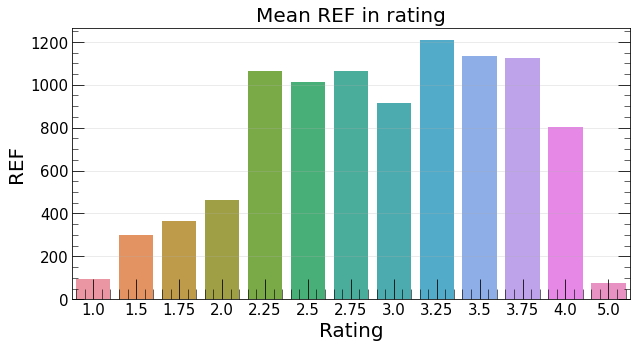

In [167]:
def distribution(data, title, x_label, y_label, figsize=(10,5)):
    plt.figure(figsize=figsize)
    plt.style.use('seaborn-pastel')
    density = sns.barplot(x=data.index, y=data.values)
    title = plt.title(title, fontdict={'fontsize': 20})
    plt.xlabel(x_label)
    plt.ylabel(y_label)
plt.show()

rating_cocoa_percent_dist = df_train.groupby('Rating')['REF'].mean()

distribution(data=rating_cocoa_percent_dist,
             title='Mean REF in rating',
             x_label='Rating',
             y_label='REF')

In [168]:
train_rating = df_train.Rating
df_train.drop('Rating', axis=1, inplace=True)
df_train['Rating'] = train_rating

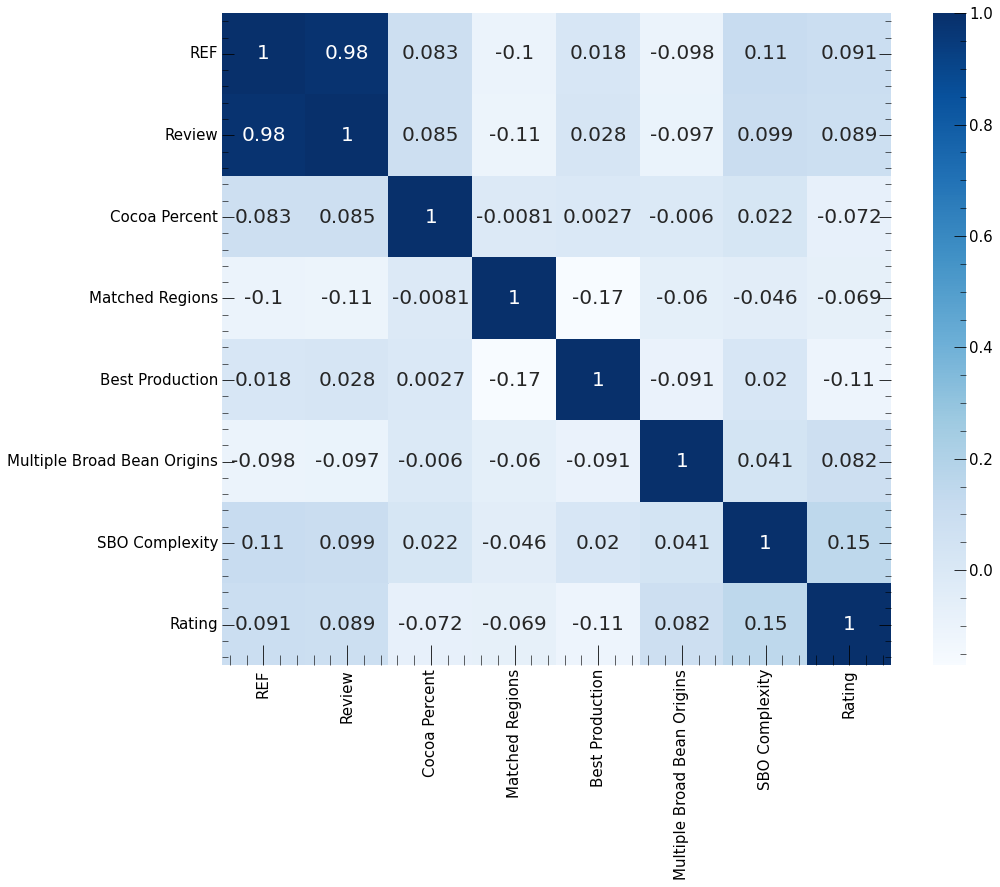

In [170]:
plt.figure(figsize = (15, 12))
plt.rcParams.update({
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
})
sns.heatmap(df_train.corr(), annot=True, cmap="Blues")

plt.show()

## Correlation matrix (categorical features)

In [171]:
import association_metrics as am

XC = df_train.apply(lambda x: x.astype("category") if x.dtype == "object" else x)
cramersv = am.CramersV(XC)
cramersv.fit()

,Company,Specific Bean Origin,Company Location,Bean Type,Broad Bean Origin,Broad Company Location,Bean Origin World
Company,1.000000,0.771841,0.999651,0.614687,0.601312,0.998263,0.630717
Specific Bean Origin,0.771841,1.000000,0.809275,0.907372,0.987266,0.843617,0.993407
Company Location,0.999651,0.809275,1.000000,0.287900,0.377435,1.000000,0.362958
Bean Type,0.614687,0.907372,0.287900,1.000000,0.369430,0.284869,0.370867
Broad Bean Origin,0.601312,0.987266,0.377435,0.369430,1.000000,0.438698,1.000000
Broad Company Location,0.998263,0.843617,1.000000,0.284869,0.438698,1.000000,0.295619
Bean Origin World,0.630717,0.993407,0.362958,0.370867,1.000000,0.295619,1.000000


In [172]:
df_train_backup = df_train.copy()
df_test_backup = df_test.copy()

In [173]:
#df_train = df_train_backup
#df_test = df_test_backup

In [174]:
#df_train.drop(['Specific Bean Origin'], axis=1, inplace=True)
#df_test.drop(['Specific Bean Origin'], axis=1, inplace=True)

In [175]:
df_train = df_train.drop(['Review'], axis=1)
df_test = df_test.drop(['Review'], axis=1)

# CatBoost with new features

In [176]:
X = df_train.drop('Rating', axis=1)
y = df_train.Rating

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [177]:
categorical_features_indices = np.where(X.dtypes == object)[0]
categorical_features_indices

array([0, 1, 4, 5, 6, 8, 9])

In [179]:
model = CatBoostRegressor()

model.fit(X_train, y_train,
         cat_features=categorical_features_indices,
         eval_set=(X_val, y_val),
         logging_level='Silent')

pred = model.predict(X_val)

r2_score(y_val, pred)

0.17626220902219925

In [180]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,22.692018
2,REF,14.579249
3,Cocoa Percent,11.883109
5,Bean Type,9.766239
6,Broad Bean Origin,8.478997
4,Company Location,8.252392
9,Bean Origin World,7.521131
8,Broad Company Location,5.597352
12,SBO Complexity,5.205838
1,Specific Bean Origin,4.201800


## CatBoost hyperparameters tuning

In [188]:
def objective(trial):

    param = {
        "n_estimators": trial.suggest_int("n_estimators", 10, 1000),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        #"learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, step=0.001)
        #"min_child_samples": trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])
    }

    estimator = CatBoostRegressor(**param,
                                  cat_features=categorical_features_indices,
                                  custom_metric='R2',
                                  verbose=False)

    estimator.fit(X_train, y_train)
    pred = estimator.predict(X_val)

    return mean_squared_error(y_val, pred)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20, n_jobs=-1)
print(study.best_trial)

[I 2023-07-10 01:13:47,819] A new study created in memory with name: no-name-38a61e0e-7c1f-4450-b622-ef5fbf8c1cf7
[I 2023-07-10 01:13:48,170] Trial 0 finished with value: 0.17680134749877802 and parameters: {'n_estimators': 36, 'max_depth': 1}. Best is trial 0 with value: 0.17680134749877802.
[I 2023-07-10 01:13:49,416] Trial 2 finished with value: 0.17522868488163254 and parameters: {'n_estimators': 601, 'max_depth': 2}. Best is trial 2 with value: 0.17522868488163254.
[I 2023-07-10 01:13:50,083] Trial 5 finished with value: 0.18358209493031397 and parameters: {'n_estimators': 90, 'max_depth': 6}. Best is trial 2 with value: 0.17522868488163254.
[I 2023-07-10 01:13:50,364] Trial 1 finished with value: 0.1976620039417624 and parameters: {'n_estimators': 159, 'max_depth': 9}. Best is trial 2 with value: 0.17522868488163254.
[I 2023-07-10 01:13:51,202] Trial 6 finished with value: 0.17810484198055182 and parameters: {'n_estimators': 876, 'max_depth': 1}. Best is trial 2 with value: 0.175

FrozenTrial(number=17, state=TrialState.COMPLETE, values=[0.17405547796126156], datetime_start=datetime.datetime(2023, 7, 10, 1, 14, 9, 455744), datetime_complete=datetime.datetime(2023, 7, 10, 1, 14, 10, 627092), params={'n_estimators': 340, 'max_depth': 2}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_estimators': IntDistribution(high=1000, log=False, low=10, step=1), 'max_depth': IntDistribution(high=10, log=False, low=1, step=1)}, trial_id=17, value=None)


In [189]:
print(study.best_trial.params)

{'n_estimators': 340, 'max_depth': 2}


In [190]:
model = CatBoostRegressor(**study.best_params,
                         cat_features=categorical_features_indices,
                         logging_level='Silent')

model.fit(X_train, y_train)
pred_cb = model.predict(X_val)

r2_score(y_val, pred_cb)

0.20085787533139765

That's better already, let's try it on test

In [191]:
pd.DataFrame({'Feature': model.feature_names_, "Importance": model.feature_importances_})\
    .sort_values(by='Importance', ascending=False)

,Feature,Importance
0,Company,32.773916
2,REF,16.254289
3,Cocoa Percent,13.577335
5,Bean Type,9.341390
12,SBO Complexity,7.141879
6,Broad Bean Origin,5.259355
4,Company Location,4.825514
9,Bean Origin World,4.713373
8,Broad Company Location,2.506789
1,Specific Bean Origin,1.734076


## Apply tuned CatBoost to test

In [192]:
model.fit(X, y)

In [193]:
pred_test = model.predict(df_test)
pred_test[:10]

array([3.13093208, 3.16207826, 3.06543733, 3.23889833, 3.01544022,
       2.94600052, 3.15209495, 3.10413658, 3.17778902, 2.77479738])

In [194]:
df_submission = df_test.copy()
df_submission['id'] = np.arange(len(df_test))
df_submission['Rating'] = pred_test
df_submission = df_submission[['id','Rating']]
df_submission.to_csv("CatBoost_v9.csv", index=False)

In [197]:
print(df_train.columns)

Index(['Company', 'Specific Bean Origin', 'REF', 'Cocoa Percent',
       'Company Location', 'Bean Type', 'Broad Bean Origin', 'Matched Regions',
       'Broad Company Location', 'Bean Origin World', 'Best Production',
       'Multiple Broad Bean Origins', 'SBO Complexity', 'Rating'],
      dtype='object')


In [199]:
print(study.best_trial.params)

{'n_estimators': 340, 'max_depth': 2}


With above features and hyperparameters I managed to get r2 = 0.18431